# Create a time series using a dask CLuster
* connect data to a horizontal slice from SMT simulation data
* examples for ssh, temperature and salinity


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
# import seawater as sw
import datetime

import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots
CPU times: user 2.12 s, sys: 2.09 s, total: 4.21 s
Wall time: 33.3 s


## Simulation details

In [95]:
run = 'ngSMT_tke'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
month = '03'

In [96]:
## choose month
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'

In [97]:
#### prep. dask cluster
search_str = f'_h_sp_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [96]:
### Temperature
#### prep. dask cluster
search_str = f'_T_S_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

optional cluster arguments:

'mfdset_kwargs = dict(combine='nested', concat_dim='flist', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )'

## create a dask Cluster

In [6]:
## Start cluster

!echo $HOSTNAME

mlogin103


In [7]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "320GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [8]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [9]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=320G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/u/u241317/PostProch7snzfaz
#SBATCH --begin=now
#SBATCH --output=/scratch/u/u241317/PostProch7snzfaz/LOG_cluster.%j.o
#SBATCH --output=/scratch/u/u241317/PostProch7snzfaz/LOG_cluster.%j.o

/work/mh0033/u241317/miniconda3/envs/pyicon_py38/bin/python -m distributed.cli.dask_worker tcp://10.50.32.32:40999 --nthreads 4 --nprocs 6 --memory-limit 53.33GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/u/u241317/PostProch7snzfaz --interface ib0 --protocol tcp://



In [10]:
cluster.scale(jobs=2)
cluster

In [21]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34298935       gpu PostProc  u241317  R    1:36:01      1 mg207
          34298934       gpu PostProc  u241317  R    1:51:01      1 mg201


In [22]:
client = Client(cluster)
client

<Client: 'tcp://10.50.32.32:40999' processes=12 threads=48, memory=639.96 GiB>

## Load data

In [23]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [98]:
%%time
dh = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs
dh = dh.assign_coords({"clon": ("ncells", clon)})
dh = dh.assign_coords({"clat": ("ncells", clat)})

#h = dh.S001_sp
h = dh.h_sp
#h = dh.T001_sp.T
h

CPU times: user 304 ms, sys: 25 ms, total: 329 ms
Wall time: 441 ms


<xarray.DataArray 'h_sp' (time: 372, ncells: 59799625)>
dask.array<concatenate, shape=(372, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -54.21 -54.22 -54.22 ... -71.82 -71.8 -71.82
    clat     (ncells) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: ncells
Attributes:
    standard_name:                height sp
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

### select region

#### select a horizontal slice

In [25]:
lon = [-75, -10]
lat = [39, 39.01]
h0 = h.where((h.clat > lat[0]) & (h.clat < lat[1]) & (h.clon > lon[0]) & (h.clon < lon[1]), drop=True)
h0

<xarray.DataArray 'h_sp' (time: 276, ncells: 11882)>
dask.array<where, shape=(276, 11882), dtype=float32, chunksize=(1, 11882), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -52.93 -52.93 -52.94 ... -10.11 -10.03 -10.14
    clat     (ncells) float64 39.0 39.01 39.0 39.0 ... 39.01 39.01 39.0 39.0
Dimensions without coordinates: ncells
Attributes:
    standard_name:                height sp
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [26]:
#ind_reg = np.argmin( (clon-lon[0])**2 + (clon-lon[1])**2 + (clat-lat[0])**2 + (clat-lat[1])**2  )  
#ind_reg = np.argmin( (clon-lon[0])**2 & (clon-lat[0])**2 )  
#ic = np.argmin( (clon-lon[0])**2 + (clat-lat[0])**2 ) 

#### selct a line section
1. Option

In [49]:
def ckdtree_section(p1, p2, npoints=101, 
                fname_tgrid='',
                path_tgrid='',
                path_ckdtree='',
                sname='auto',
                gname='',
                tgname='',
                n_nearest_neighbours=1,
                n_jobs=1,
                load_cgrid=True,
                load_egrid=True,
                load_vgrid=True,
                save_as_nc=True,
                ):
    
 """
 """
 if tgname=='':
    Drgrid = identify_grid(path_tgrid, path_tgrid+fname_tgrid) 
    tgname = Drgrid['name']
 lon1str, lat1str = pyic.lonlat2str(p1[0], p1[1])
 lon2str, lat2str = pyic.lonlat2str(p2[0], p2[1])
 if sname=='auto':
   sname = fpath_ckdtree.split('/')[-1][:-4]
 if save_as_nc:
   ending='nc'
 else:
   ending='npz'
 #fname = '%s_nps%d_%s%s_%s%s.npz'%(tgname, npoints, lon1str, lat1str, lon2str, lat2str) 
 fname = f'{tgname}_nps{npoints:d}_{lon1str}{lat1str}_{lon2str}{lat2str}.{ending}'
 fpath_ckdtree = path_ckdtree+fname
 fpath_tgrid   = path_tgrid+fname_tgrid
 # --- derive section points
 lon_sec, lat_sec, dist_sec = pyic.derive_section_points(p1, p2, npoints)
 lon_o = lon_sec
 lat_o = lat_sec
 # --- calculate ckdtree
 Dind_dist = pyic.ckdtree_points(fpath_tgrid, lon_o, lat_o, load_cgrid=load_cgrid, load_egrid=load_egrid, load_vgrid=load_vgrid, n_nearest_neighbours=n_nearest_neighbours,
                            n_jobs=n_jobs)
 # --- save grid
 print('Saving grid file: %s' % (fpath_ckdtree))
 if save_as_nc:
   ds = xr.Dataset()
   ds['lon_sec'] = xr.DataArray(lon_sec, dims=['isec'])
   ds['lat_sec'] = xr.DataArray(lat_sec, dims=['isec'])
   ds['dist_sec'] = xr.DataArray(dist_sec, dims=['isec'])
   for var in Dind_dist.keys(): 
     ds[var] = xr.DataArray(Dind_dist[var], dims=['isec'])
   ds.to_netcdf(fpath_to_indices)
 else:
   np.savez(fpath_ckdtree,
             lon_sec=lon_sec,
             lat_sec=lat_sec,
             dist_sec=dist_sec,
             sname=sname,
             gname=gname,
             **Dind_dist
            )
 return Dind_dist['dckdtree_c'], Dind_dist['ickdtree_c'], lon_sec, lat_sec, dist_sec

In [58]:
# carfully choose npoints to have only unique values
# pyicon function has to be adapted, select save directory
sname = '75_10W_39N'
path_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
tgname        = 'smt'
gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
fname_tgrid   = f'{gname}.nc'
path_ckdtree  = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{tgname}/ckdtree/'
path_rgrid    = path_ckdtree + 'rectgrids/'
path_sections = path_ckdtree + 'sections/'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_to_indices = path_scratch + 'indices.nc'


dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = ckdtree_section(p1=[lon[1],lat[0]], p2=[lon[0],lat[0]], npoints=4000,
                      fname_tgrid  = fname_tgrid,
                      path_tgrid   = path_tgrid,
                      path_ckdtree = path_sections,
                      sname = sname,
                      gname = gname,
                      tgname = tgname,
                      load_egrid=False,
                      load_vgrid=False,
                      )

Saving grid file: /mnt/lustre01/work/mh0033/m300602/icon/grids/smt/ckdtree/sections/smt_nps4000_10W39N_75W39N.nc


In [99]:
h1 = dh.isel(ncells=ickdtree)
h1 = h1.assign_coords({"rlon": ("ncells", lon_sec)}) #keep old lat and lon TODO overwrite
h1 = h1.assign_coords({"rlat": ("ncells", lat_sec)})
h1

<xarray.Dataset>
Dimensions:  (time: 372, ncells: 4000)
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -9.998 -10.02 -10.03 ... -74.97 -74.98 -75.0
    clat     (ncells) float64 39.0 38.99 39.0 39.0 39.01 ... 39.0 39.0 39.0 39.0
    rlon     (ncells) float64 -10.0 -10.02 -10.03 -10.05 ... -74.97 -74.98 -75.0
    rlat     (ncells) float64 39.0 39.0 39.0 39.0 39.0 ... 39.0 39.0 39.0 39.0
Dimensions without coordinates: ncells
Data variables:
    h_sp     (time, ncells) float32 dask.array<chunksize=(1, 4000), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20054 (Linux 2.6....

Visualisation of nearest neighbour method:

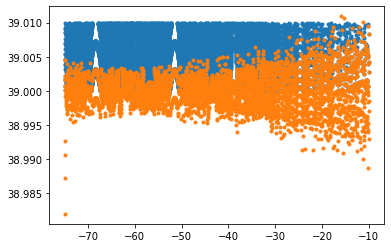

In [72]:
plt.scatter(h0.clon, h0.clat, marker=".")
plt.scatter(lon_sec, h1.clat, marker=".")

### compute and save data

In [100]:
#fpath = f'{path_scratch}/time_series_analysis_ssh_2d_1.nc'
fpath = f'{path_scratch}/time_series_ssh_line_{month}1.nc'
print(f'Saving file {fpath}')
h1.to_netcdf(fpath)

Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//time_series_ssh_line_031.nc


repeat this process for the three simulated month of the SMT datasets - dont forget to change filenames ;)

### combine data of 3 month using time

In [102]:
#### prep. dask cluster
path_data = path_scratch
#search_str = f'time_series_analysis_ssh_2d_*.nc' 
search_str = f'time_series_ssh_line*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
flist

array(['/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_011.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_021.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_031.nc'],
      dtype='<U65')

In [103]:
dH = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs

### save final dataset

In [104]:
#fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_ssh_2d.nc'
fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_ssh_line.nc'
print(f'Saving file {fpath}')
dH.to_netcdf(fpath)

Saving file /work/mh0033/u241317/smt/time_series_analysis/time_series_ssh_line.nc


#### a first glance on the new dataset

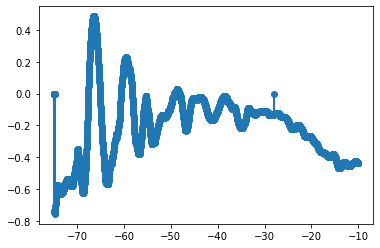

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

tt = dH.isel(ncells=500)
#fig, ax = plt
plt.plot( dH.rlon, dH.h_sp.isel(time=1), marker="o")
#plt.show()

#### close cluster properly

In [114]:
client.close()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


# other trys

In [173]:
#def interp_to_rectgrid(data, fpath_ckdtree, 
#                       lon_reg=None, lat_reg=None,             # for new way of cropping
#                       indx='all', indy='all', mask_reg=None,  # for old way of cropping
#                       coordinates='clat clon'):

lon = [-75, -10]
lat = [39, 39.01]

def get_mask(data, fpath_ckdtree,
             lon_reg=None, lat_reg=None,             # for new way of cropping
             indx='all', indy='all', mask_reg=None,  # for old way of cropping
             coordinates='clat clon'):
    #lon_reg = lon, lat_reg=(lat[0],lat[0]+0.02)
    #data = h.isel(time=1)

    #indx='all'
    #coordinates='clat clon'
    ddnpz = np.load(fpath_ckdtree)
    lon = ddnpz['lon'] 
    lat = ddnpz['lat'] 
    # --- old way of cropping
    if not isinstance(indx, str): 
        lon = lon[indx]
        lat = lat[indy]
     # --- prepare cropping the data to a region
    if lon_reg is not None:
        indx = np.where((lon>=lon_reg[0]) & (lon<lon_reg[1]))[0]
        indy = np.where((lat>=lat_reg[0]) & (lat<lat_reg[1]))[0]
        Lon, Lat = np.meshgrid(lon, lat) # full grid
        lon = lon[indx]
        lat = lat[indy]
        ind_reg = ((Lon>=lon_reg[0]) & (Lon<lon_reg[1]) & (Lat>=lat_reg[0]) & (Lat<lat_reg[1])).flatten()
        mask_reg = ind_reg
        Lon, Lat = np.meshgrid(lon, lat) # cropped grid
        return lon, lat, mask_reg


In [224]:
ind_reg = ((Lon>=lon_reg[0]) & (Lon<lon_reg[1]) & (Lat>=lat_reg[0]) & (Lat<lat_reg[1]))

In [265]:
%%time
lon, lat, mask_reg = get_mask(data=h.isel(time=1), fpath_ckdtree=fpath_ckdtree, lon_reg = lon, lat_reg=(lat[0],lat[0]+0.02))

CPU times: user 1.13 s, sys: 1.47 s, total: 2.6 s
Wall time: 2.33 s


In [276]:
H = xr.Dataset()
H = H.assign_coords({"lon": ("ncells", lon)})
#H = H.assign_coords({"lat": ("ncells", lat)})

In [295]:
dat = np.zeros([N, lon.size])

In [298]:
dat.shape

(276, 3250)

In [302]:
%%time
N = h.time.size
coordinates='clat clon'
for t in np.arange(5):
    datai = pyic.apply_ckdtree(h.isel(time=t), fpath_ckdtree, mask=mask_reg, coordinates=coordinates)
    datai = datai.reshape(lat.size, lon.size)
    datai[datai==0.] = np.ma.masked
    dat[t,:] = datai
    #dat = xr.DataArray(data=datai, dims=["time", "ncells"])
    #H = xr.merge(H,dat,concat_dim='time')


CPU times: user 22.4 s, sys: 14.3 s, total: 36.7 s
Wall time: 41.4 s


In [321]:
mask_reg.reshape(Lon. size,Lat.size)

ValueError: cannot reshape array of size 162000000 into shape (3250,3250)

In [309]:
#H = xr.Dataset(dat, coords={"time": dat[:,1], "lon": ("ncells", lon)})
#H = H.assign_coords({"lon": ("ncells", lon)})
ds = xr.DataArray(data=dat, dims=["time", "ncells"], coords={"lon": ("ncells",lon)})

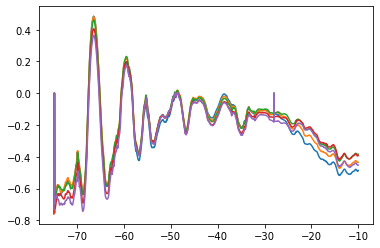

In [317]:
for i in range(5):
    plt.plot(ds.lon, ds.isel(time=i))

In [213]:
%%time
lon = [-75, -10]
lat = [39, 39.01]
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
lon_r, lat_r, h1 = pyic.interp_to_rectgrid(h.isel(time=1), fpath_ckdtree, lon_reg=lon, lat_reg=(lat[0],lat[0]+0.02), mask_reg=mask)

CPU times: user 6.51 s, sys: 4.75 s, total: 11.3 s
Wall time: 11.6 s


In [241]:
%%time
lon = [-75, -10]
lat = [39, 39.01]
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
lon_r, lat_r, h1 = pyic.interp_to_rectgrid_xr(h.isel(time=1), fpath_ckdtree, lon_reg=lon, lat_reg=(lat[0],lat[0]+0.02))

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'cfgrib']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [257]:
print(netCDF4.__version__)
print(cfgrib.__version__)
print(scipy.__version__)
print(xr.__version__)
print(np.__version__)

1.5.6
0.9.9.1
1.6.3
0.20.1
1.21.4


In [258]:
!pip show numpy

Name: numpy
Version: 1.21.4
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /mnt/lustre01/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages
Requires: 
Required-by: xarray, timezonefinder, seawater, scipy, sankee, pandas, netCDF4, matplotlib, gsw, geemap, folium, eccodes, colorspacious, cftime, cfgrib, Cartopy, bqplot, bokeh


In [260]:
! pip freeze | grep xarray

xarray @ file:///home/conda/feedstock_root/build_artifacts/xarray_1636334359499/work
